In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

In [7]:
csv_folder_path = './data/csv'
participants_info_path = os.path.join(csv_folder_path, 'participants_info.csv')
participants_df = pd.read_csv(participants_info_path)

In [9]:
def extract_perg_features(perg_df):
    features = {}
    perg_columns = [col for col in perg_df.columns if col.startswith('RE_') or col.startswith('LE_')]
    for col in perg_columns:
        signal = perg_df[col].dropna()
        features[f'{col}_mean'] = signal.mean()
        features[f'{col}_std'] = signal.std()
        features[f'{col}_max'] = signal.max()
        features[f'{col}_min'] = signal.min()
        features[f'{col}_peak_to_peak'] = signal.max() - signal.min()
    return pd.Series(features)

In [11]:
participants_df['id_record'] = participants_df['id_record'].astype(str).str.zfill(4)

perg_files = glob.glob(os.path.join(csv_folder_path, '*.csv'))
perg_files = [file for file in perg_files if 'participants_info' not in os.path.basename(file)]
perg_features_list = []
for file in perg_files:
    perg_df = pd.read_csv(file)
    filename = os.path.basename(file)
    id_record = os.path.splitext(filename)[0]
    id_record = id_record.zfill(4)
    
    features = extract_perg_features(perg_df)
    features['id_record'] = id_record
    perg_features_list.append(features)

perg_features_df = pd.DataFrame(perg_features_list)
display(perg_features_df.head())

,RE_1_mean,RE_1_std,RE_1_max,RE_1_min,RE_1_peak_to_peak,LE_1_mean,LE_1_std,LE_1_max,LE_1_min,LE_1_peak_to_peak,...,RE_5_mean,RE_5_std,RE_5_max,RE_5_min,RE_5_peak_to_peak,LE_5_mean,LE_5_std,LE_5_max,LE_5_min,LE_5_peak_to_peak
0,-1.406667,2.954510,5.0,-6.7,11.7,1.853333,2.323497,7.4,-2.1,9.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.340392,1.025605,0.5,-3.4,3.9,-2.376471,1.351871,1.0,-4.3,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.294902,1.560718,1.6,-3.7,5.3,0.378824,1.345517,3.0,-2.5,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.690980,1.564806,0.7,-3.9,4.6,2.511373,1.500259,5.5,-0.3,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.725490,2.129327,8.4,-0.6,9.0,1.579608,0.799641,3.3,0.0,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
perg_features_df.columns

Index(['RE_1_mean', 'RE_1_std', 'RE_1_max', 'RE_1_min', 'RE_1_peak_to_peak',
       'LE_1_mean', 'LE_1_std', 'LE_1_max', 'LE_1_min', 'LE_1_peak_to_peak',
       'id_record', 'RE_2_mean', 'RE_2_std', 'RE_2_max', 'RE_2_min',
       'RE_2_peak_to_peak', 'LE_2_mean', 'LE_2_std', 'LE_2_max', 'LE_2_min',
       'LE_2_peak_to_peak', 'RE_3_mean', 'RE_3_std', 'RE_3_max', 'RE_3_min',
       'RE_3_peak_to_peak', 'LE_3_mean', 'LE_3_std', 'LE_3_max', 'LE_3_min',
       'LE_3_peak_to_peak', 'RE_4_mean', 'RE_4_std', 'RE_4_max', 'RE_4_min',
       'RE_4_peak_to_peak', 'LE_4_mean', 'LE_4_std', 'LE_4_max', 'LE_4_min',
       'LE_4_peak_to_peak', 'RE_5_mean', 'RE_5_std', 'RE_5_max', 'RE_5_min',
       'RE_5_peak_to_peak', 'LE_5_mean', 'LE_5_std', 'LE_5_max', 'LE_5_min',
       'LE_5_peak_to_peak'],
      dtype='object')

In [13]:
merged_df = pd.merge(participants_df, perg_features_df, on='id_record', how='inner')
merged_df['retina_problem'] = merged_df['diagnosis1'].apply(lambda x: 0 if x == "Normal" else 1)
merged_df = merged_df.drop(columns=['diagnosis1', 'diagnosis2', 'diagnosis3', 'date', 'unilateral', 'rep_record', 'comments'])
merged_df['sex'] = merged_df['sex'].apply(lambda x: 0 if x == "Female" else 1)
merged_df['retina_problem'].value_counts()

retina_problem
1    230
0    106
Name: count, dtype: int64

In [61]:
missing_cols = []
missing_cols = missing_cols + [col for col in merged_df.columns if col.startswith('RE_3') or col.startswith('LE_3')]
missing_cols = missing_cols + [col for col in merged_df.columns if col.startswith('RE_4') or col.startswith('LE_4')]
missing_cols = missing_cols + [col for col in merged_df.columns if col.startswith('RE_5') or col.startswith('LE_5')]
merged_df = merged_df.drop(columns=missing_cols)

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_record          336 non-null    object 
 1   age_years          336 non-null    int64  
 2   sex                336 non-null    int64  
 3   va_re_logMar       317 non-null    float64
 4   va_le_logMar       317 non-null    float64
 5   RE_1_mean          336 non-null    float64
 6   RE_1_std           336 non-null    float64
 7   RE_1_max           336 non-null    float64
 8   RE_1_min           336 non-null    float64
 9   RE_1_peak_to_peak  336 non-null    float64
 10  LE_1_mean          336 non-null    float64
 11  LE_1_std           336 non-null    float64
 12  LE_1_max           336 non-null    float64
 13  LE_1_min           336 non-null    float64
 14  LE_1_peak_to_peak  336 non-null    float64
 15  RE_2_mean          287 non-null    float64
 16  RE_2_std           287 non

In [19]:
for col in merged_df.columns:
    if merged_df[col].isna().sum() > 0:
        merged_df[col] = merged_df[col].fillna(merged_df[col].mean())

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_record          336 non-null    object 
 1   age_years          336 non-null    int64  
 2   sex                336 non-null    int64  
 3   va_re_logMar       336 non-null    float64
 4   va_le_logMar       336 non-null    float64
 5   RE_1_mean          336 non-null    float64
 6   RE_1_std           336 non-null    float64
 7   RE_1_max           336 non-null    float64
 8   RE_1_min           336 non-null    float64
 9   RE_1_peak_to_peak  336 non-null    float64
 10  LE_1_mean          336 non-null    float64
 11  LE_1_std           336 non-null    float64
 12  LE_1_max           336 non-null    float64
 13  LE_1_min           336 non-null    float64
 14  LE_1_peak_to_peak  336 non-null    float64
 15  RE_2_mean          336 non-null    float64
 16  RE_2_std           336 non

In [27]:
X = merged_df.drop(columns=['id_record', 'retina_problem'])
y = merged_df[['retina_problem']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [29]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
[[12 15]
 [15 42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        27
           1       0.74      0.74      0.74        57

    accuracy                           0.64        84
   macro avg       0.59      0.59      0.59        84
weighted avg       0.64      0.64      0.64        84

Accuracy Score: 0.64


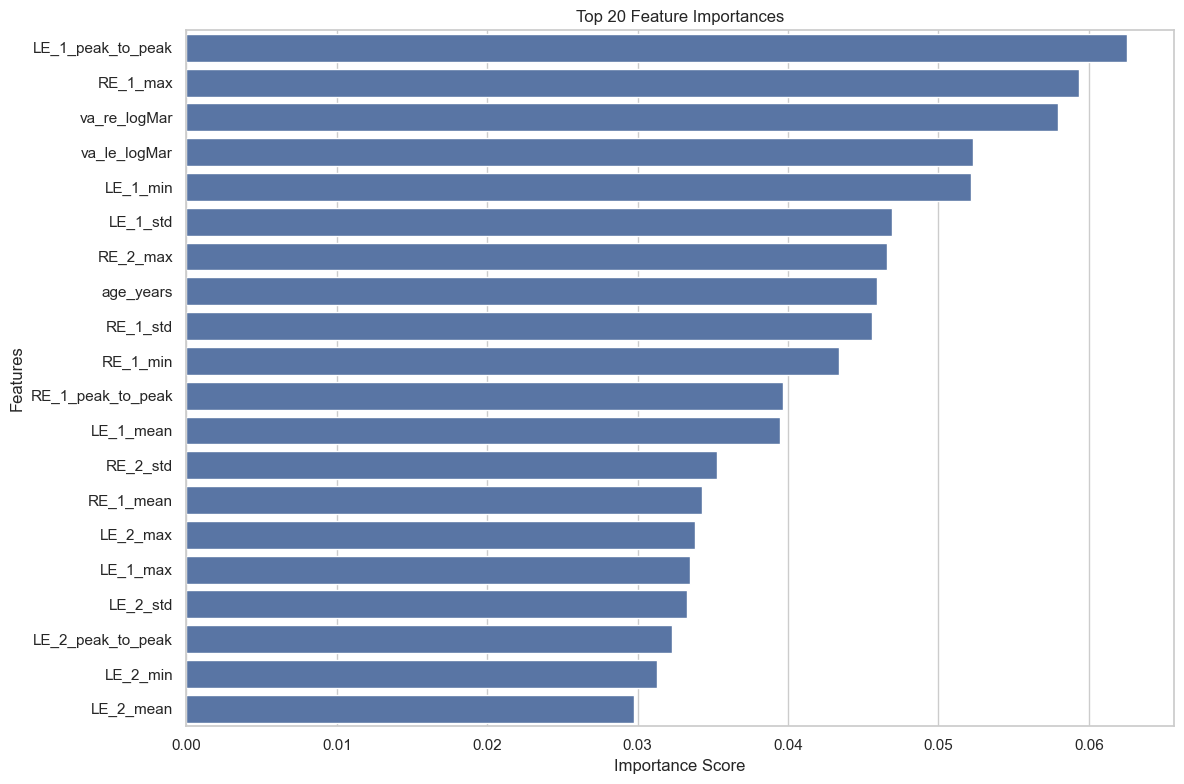

In [31]:
importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [73]:
xgb_classifier = XGBClassifier(n_estimators=250, random_state=42, learning_rate=0.1,  max_depth=3)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
[[13 14]
 [18 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.48      0.45        27
           1       0.74      0.68      0.71        57

    accuracy                           0.62        84
   macro avg       0.58      0.58      0.58        84
weighted avg       0.63      0.62      0.63        84

Accuracy Score: 0.62


In [77]:
merged_df.to_csv('participants_merged_a2.csv', index=False)